In [399]:
from __future__ import division
import numpy as np
import pandas as pd
import os, sys,time
import vcf
import gzip
from Bio import SeqIO
from collections import OrderedDict, Counter
import random

In [8]:
vcftools = "/home/lindb/g/src/vcftools_0.1.13/bin/vcftools"
bcftools = "/home/lindb/g/src/bcftools-1.3/bcftools"
tabix = "/home/lindb/g/src/htslib-1.3/tabix"
bgzip = "/home/lindb/g/src/htslib-1.3/bgzip"
plink = "/home/lindb/g/src/plink-1.07-x86_64/plink --noweb"
java  = "/home/lindb/g/src/jre1.8.0_73/bin/java"

In [5]:
snp_dir = '/home/lindb/wbp/concatenated/snps/'
vcf_file = os.path.join(snp_dir,'samtools_1.3.vcf.gz')

In [6]:
assert os.path.exists(vcf_file)

In [7]:
!$vcftools --remove-indels \
--max-missing 0.5 \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $vcf_file

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--max-missing 0.5
	--out /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting VCF file...
After filtering, kept 1300961 out of a possible 2892582 Sites
Run Time = 5448.00 seconds


In [9]:
vcf_filtered = "%s.recode.vcf" % vcf_file
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [10]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'


In [11]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-indv',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [12]:
get_vcf_stats(vcf_filtered_gz)

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--depth
	--out /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting Mean Depth by Individual
After filtering, kept 1300961 out of a possible 1300961 Sites
Run Time = 1207.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--out /home/lindb/wbp/concatenated/snps/s

In [17]:
files = os.listdir(snp_dir)

In [19]:
[os.path.join(snp_dir,f) for f in files if '.l' in f and 'log' not in f]

['/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz.ldepth',
 '/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz.ldepth.mean',
 '/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz.lqual',
 '/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz.lmiss']

In [41]:
pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    #hardy_files = !ls {filedir}/{prefix}*.hwe
    print "hardy files"
    files = os.listdir(filedir)
    hardy_files = [os.path.join(filedir,f) for f in files if f.endswith('hwe')]
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    print "loci files"
    #loci_files = !ls {filedir}/{prefix}*.l* | grep -v log
    loci_files = [os.path.join(filedir,f) for f in files if '.l' in f and 'log' not in f]
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    print "frq files"
    #frq_files = !ls {filedir}/{prefix}*.frq* | grep -v count
    frq_files = [os.path.join(filedir,f) for f in files if f.endswith('frq')]
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    print "loci df"
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    print "identifying alleles"
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    print "calculating allele freqs"
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    print "getting MAF"
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    print "calculating FIS"
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    print 'done'
    return loci_df, frq_df, hardy

In [21]:
snp_dir

'/home/lindb/wbp/concatenated/snps/'

In [25]:
loci_df, frq_df, hardy = combine_vcf_stats(snp_dir, "samtools")

hardy files
loci files
frq files
Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
finishing


In [33]:
loci_df.head()

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
NODE_16_length_56_cov_1.375000-61,434,2138,1.77869,5.6216,591,488,0,212,0.434426,2,276,A:0,T:1,0/0/138,0.00/0.00/138.00,NaN,1.000000e+00,1.000000e+00,1.000000,A,T,0.000000,1.000000,0.000000,NaN
NODE_73_length_45_cov_1.955556-63,1063,9127,4.35656,18.5020,334,488,0,96,0.196721,2,392,T:0.168367,C:0.831633,17/32/147,5.56/54.89/135.56,34.080940,1.870726e-07,1.870726e-07,1.000000,T,C,0.168367,0.831633,0.168367,0.418479
NODE_117_length_99_cov_3.979798-22,17558,2525410,71.95900,5193.2200,999,488,0,40,0.081967,2,448,T:0.00892857,C:0.991071,0/4/220,0.02/3.96/220.02,0.018180,1.000000e+00,1.000000e+00,0.986592,T,C,0.008929,0.991071,0.008929,-0.006757
NODE_117_length_99_cov_3.979798-45,2732,66896,11.19670,149.4100,999,488,0,86,0.176230,2,402,T:0.0348259,A:0.965174,0/14/187,0.24/13.51/187.24,0.261691,1.000000e+00,1.000000e+00,0.791139,T,A,0.034826,0.965174,0.034826,-0.033505
NODE_117_length_99_cov_3.979798-46,2726,66620,11.17210,148.8260,999,488,0,86,0.176230,2,402,T:0.0174129,A:0.982587,0/7/194,0.06/6.88/194.06,0.063125,1.000000e+00,1.000000e+00,0.948286,T,A,0.017413,0.982587,0.017413,-0.015190


In [27]:
frq_df.head()

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
NODE_16_length_56_cov_1.375000-61,NODE_16_length_56_cov_1.375000,61,2,276,A:0,T:1
NODE_73_length_45_cov_1.955556-63,NODE_73_length_45_cov_1.955556,63,2,392,T:0.168367,C:0.831633
NODE_117_length_99_cov_3.979798-22,NODE_117_length_99_cov_3.979798,22,2,448,T:0.00892857,C:0.991071
NODE_117_length_99_cov_3.979798-45,NODE_117_length_99_cov_3.979798,45,2,402,T:0.0348259,A:0.965174
NODE_117_length_99_cov_3.979798-46,NODE_117_length_99_cov_3.979798,46,2,402,T:0.0174129,A:0.982587


In [28]:
hardy.head()

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
NODE_16_length_56_cov_1.375000-61,NODE_16_length_56_cov_1.375000,61,0/0/138,0.00/0.00/138.00,NaN,1.000000e+00,1.000000e+00,1.000000
NODE_73_length_45_cov_1.955556-63,NODE_73_length_45_cov_1.955556,63,17/32/147,5.56/54.89/135.56,34.080940,1.870726e-07,1.870726e-07,1.000000
NODE_117_length_99_cov_3.979798-22,NODE_117_length_99_cov_3.979798,22,0/4/220,0.02/3.96/220.02,0.018180,1.000000e+00,1.000000e+00,0.986592
NODE_117_length_99_cov_3.979798-45,NODE_117_length_99_cov_3.979798,45,0/14/187,0.24/13.51/187.24,0.261691,1.000000e+00,1.000000e+00,0.791139
NODE_117_length_99_cov_3.979798-46,NODE_117_length_99_cov_3.979798,46,0/7/194,0.06/6.88/194.06,0.063125,1.000000e+00,1.000000e+00,0.948286


In [29]:
loci_file = '/home/lindb/wbp/concatenated/snps/loci_vcf_stats.txt'
loci_df.to_csv(loci_file,header=True,index=True,sep="\t")

In [30]:
frq_file = '/home/lindb/wbp/concatenated/snps/frq_vcf_stats.txt'
frq_df.to_csv(frq_file,header=True,index=True,sep="\t")

In [31]:
hardy_file = '/home/lindb/wbp/concatenated/snps/hwe_vcf_stats.txt'
hardy.to_csv(hardy_file,header=True,index=True,sep="\t")

# Impute with Beagle

    cd /home/lindb/wbp/concatenated/snps/beagle40
    ln -s ../samtools_1.3.vcf.gz.recode.vcf.gz
    /home/lindb/g/src/jdk1.8.0_73/bin/java -jar ~/g/src/BEAGLE4/beagle.r1399.jar \
    gl=samtools_1.3.vcf.gz.recode.vcf.gz \
    out=beagle40 \
    nthreads=32 \
    phase-its=20 \
    burnin-its=20 \
    impute-its=20

In [34]:
beagle_dir = os.path.join(snp_dir, "beagle40")

In [36]:
beagle_vcf_gz = os.path.join(beagle_dir, "beagle40.vcf.gz")
assert os.path.exists(beagle_vcf_gz)

In [37]:
get_vcf_stats(beagle_vcf_gz)

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/beagle40/beagle40.vcf.gz
	--depth
	--out /home/lindb/wbp/concatenated/snps/beagle40/beagle40.vcf.gz

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting Mean Depth by Individual
After filtering, kept 1300961 out of a possible 1300961 Sites
Run Time = 144.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/beagle40/beagle40.vcf.gz
	--out /home/lindb/wbp/concatenated/snps/beagle40/beagle40.vcf.gz
	--s

In [40]:
beagle_dir

'/home/lindb/wbp/concatenated/snps/beagle40'

In [42]:
loci_df_beagle, freq_df_beagle, hardy_beagle = combine_vcf_stats(beagle_dir, "beagle40")

hardy files
loci files
frq files
Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
loci df
identifying alleles
calculating allele freqs
getting MAF
calculating FIS
done


In [91]:
loci_df_beagle

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
NODE_16_length_56_cov_1.375000-61,0,0,NaN,NaN,-1,488,0,0,0,2,488,A:0,T:1,0/0/244,0.00/0.00/244.00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,A,T,0.000000,1.000000,0.000000,NaN
NODE_73_length_45_cov_1.955556-63,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.0122951,C:0.987705,0/6/238,0.04/5.93/238.04,0.037809,1.000000e+00,1.000000e+00,9.693896e-01,T,C,0.012295,0.987705,0.012295,-0.010373
NODE_117_length_99_cov_3.979798-22,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.00204918,C:0.997951,0/1/243,0.00/1.00/243.00,0.001029,1.000000e+00,1.000000e+00,1.000000e+00,T,C,0.002049,0.997951,0.002049,0.000000
NODE_117_length_99_cov_3.979798-45,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.0204918,A:0.979508,0/10/234,0.10/9.80/234.10,0.106791,1.000000e+00,1.000000e+00,9.102373e-01,T,A,0.020492,0.979508,0.020492,-0.018828
NODE_117_length_99_cov_3.979798-46,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.0204918,A:0.979508,0/10/234,0.10/9.80/234.10,0.106791,1.000000e+00,1.000000e+00,9.102373e-01,T,A,0.020492,0.979508,0.020492,-0.018828
NODE_117_length_99_cov_3.979798-64,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.0204918,G:0.979508,0/10/234,0.10/9.80/234.10,0.106791,1.000000e+00,1.000000e+00,9.102373e-01,T,G,0.020492,0.979508,0.020492,-0.018828
NODE_117_length_99_cov_3.979798-72,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.258197,C:0.741803,4/118/122,16.27/93.47/134.27,16.809900,1.834113e-05,9.999986e-01,1.048217e-05,T,C,0.258197,0.741803,0.258197,-0.259888
NODE_117_length_99_cov_3.979798-82,0,0,NaN,NaN,-1,488,0,0,0,2,488,A:0.122951,G:0.877049,0/60/184,3.69/52.62/187.69,4.795179,3.172595e-02,1.000000e+00,1.585835e-02,A,G,0.122951,0.877049,0.122951,-0.137850
NODE_117_length_99_cov_3.979798-97,0,0,NaN,NaN,-1,488,0,0,0,2,488,T:0.215164,C:0.784836,6/93/145,11.30/82.41/150.30,4.031129,5.683300e-02,9.887311e-01,3.198435e-02,T,C,0.215164,0.784836,0.215164,-0.126222
NODE_117_length_99_cov_3.979798-98,0,0,NaN,NaN,-1,488,0,0,0,2,488,A:0.153689,C:0.846311,7/61/176,5.76/63.47/174.76,0.370495,4.699040e-01,3.337456e-01,8.160896e-01,A,C,0.153689,0.846311,0.153689,0.040936


In [44]:
freq_df_beagle.head()

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
NODE_16_length_56_cov_1.375000-61,NODE_16_length_56_cov_1.375000,61,2,488,A:0,T:1
NODE_73_length_45_cov_1.955556-63,NODE_73_length_45_cov_1.955556,63,2,488,T:0.0122951,C:0.987705
NODE_117_length_99_cov_3.979798-22,NODE_117_length_99_cov_3.979798,22,2,488,T:0.00204918,C:0.997951
NODE_117_length_99_cov_3.979798-45,NODE_117_length_99_cov_3.979798,45,2,488,T:0.0204918,A:0.979508
NODE_117_length_99_cov_3.979798-46,NODE_117_length_99_cov_3.979798,46,2,488,T:0.0204918,A:0.979508


In [45]:
hardy_beagle.head()

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
NODE_16_length_56_cov_1.375000-61,NODE_16_length_56_cov_1.375000,61,0/0/244,0.00/0.00/244.00,NaN,1,1,1.000000
NODE_73_length_45_cov_1.955556-63,NODE_73_length_45_cov_1.955556,63,0/6/238,0.04/5.93/238.04,0.037809,1,1,0.969390
NODE_117_length_99_cov_3.979798-22,NODE_117_length_99_cov_3.979798,22,0/1/243,0.00/1.00/243.00,0.001029,1,1,1.000000
NODE_117_length_99_cov_3.979798-45,NODE_117_length_99_cov_3.979798,45,0/10/234,0.10/9.80/234.10,0.106791,1,1,0.910237
NODE_117_length_99_cov_3.979798-46,NODE_117_length_99_cov_3.979798,46,0/10/234,0.10/9.80/234.10,0.106791,1,1,0.910237


In [46]:
loci_beagle_file = os.path.join(beagle_dir,'loci_beagle_vcf_stats.txt')
loci_df_beagle.to_csv(loci_beagle_file,header=True,index=True,sep="\t")

In [47]:
freq_beagle = os.path.join(beagle_dir,'frq_beagle_vcf_stats.txt')
freq_df_beagle.to_csv(freq_beagle,header=True,index=True,sep="\t")

In [48]:
hardy_beagle_file = os.path.join(beagle_dir,'hwe_beagle_vcf_stats.txt')
hardy_beagle.to_csv(hardy_beagle_file,header=True,index=True,sep="\t")

In [49]:
chroms = sorted(set([x.split("-")[0] for x in loci_df.index]))

In [52]:
snp_dir

'/home/lindb/wbp/concatenated/snps/'

In [53]:
with open(os.path.join(snp_dir, "chrom_map.txt"), "w") as o:
    for i, c in enumerate(chroms):
        o.write("%s\t%d\n" % (c, i))

In [55]:
def write_plink_files(vcf_gz):
    !$vcftools --gzvcf {vcf_gz} \
    --out {vcf_gz} \
    --plink \
    --chrom-map {os.path.join(snp_dir, "chrom_map.txt")}

In [56]:
vcf_filtered_gz

'/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz'

In [57]:
write_plink_files(vcf_filtered_gz)

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--chrom-map /home/lindb/wbp/concatenated/snps/chrom_map.txt
	--out /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--plink

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Writing PLINK PED and MAP files ... 
	Read 178750 chromosome mapping file entries.
Done.
After filtering, kept 1300961 out of a possible 1300961 Sites
Run Time = 346.00 seconds


In [58]:
def write_plink_recode(vcf_gz):
    !$plink --recodeA --tab --file {vcf_gz} --out {vcf_gz}_recodeA

In [60]:
write_plink_recode(vcf_filtered_gz)

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz_recodeA.log ]
Analysis started: Tue Feb 16 12:11:59 2016

Options in effect:
	--noweb
	--recodeA
	--tab
	--file /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--out /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.reco

In [61]:
loci_df.SUM_DEPTH.describe()

count    1300961.000000
mean        1745.176835
std         3104.671683
min          139.000000
25%          535.000000
50%          870.000000
75%         1671.000000
max        56722.000000
Name: SUM_DEPTH, dtype: float64

In [68]:
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

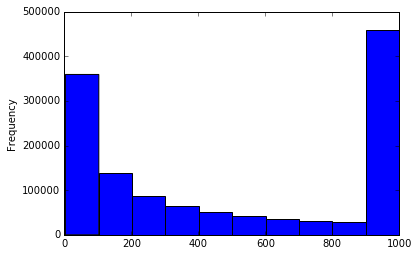

In [69]:
loci_df.QUAL.plot(kind="hist")

In [72]:
len(loci_df[loci_df.Fis == -9])

0

In [73]:
len(loci_df[loci_df.QUAL >= 10]) - len(loci_df[loci_df.QUAL >= 20])

56817

In [74]:
len(loci_df[loci_df.QUAL < 20]), len(loci_df[loci_df.QUAL < 10])

(122399, 65582)

In [75]:
len(loci_df[loci_df.Fis >= 0.5]), len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(16515, 28411, 122951)

In [77]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) & 
                  (df.Fis < 0.5) & 
                  (df.Fis > -0.5)]
    else:
        return df[(df.SUM_DEPTH >= 100) & 
                  (df.SUM_DEPTH < 1500) & 
                  (df.QUAL >= 20) & 
                  (df.MAF >= 0.01) & 
                  (df.Fis < 0.5) & 
                  (df.Fis > -0.5)]

In [78]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(778406, 25)

In [455]:
loci_stage1.head()

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,QUAL,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
NODE_73_length_45_cov_1.955556-63,1063,9127,4.35656,18.5020,334,488,0,96,0.196721,2,392,T:0.168367,C:0.831633,17/32/147,5.56/54.89/135.56,34.080940,1.870726e-07,1.870726e-07,1.000000,T,C,0.168367,0.831633,0.168367,0.418479
NODE_162_length_98_cov_5.010204-17,678,6288,2.77869,18.1237,371,488,0,216,0.442623,2,272,G:0.944853,A:0.0551471,121/15/0,121.41/14.17/0.41,0.463292,1.000000e+00,1.000000e+00,0.664991,G,A,0.944853,0.055147,0.055147,-0.054475
NODE_162_length_98_cov_5.010204-27,732,7434,3.00000,21.5556,187,488,0,214,0.438525,2,274,C:0.967153,T:0.0328467,128/9/0,128.15/8.70/0.15,0.158021,1.000000e+00,1.000000e+00,0.873178,C,T,0.967153,0.032847,0.032847,-0.030189
NODE_162_length_98_cov_5.010204-28,742,7634,3.04098,22.1300,181,488,0,214,0.438525,2,274,G:0.970803,A:0.0291971,129/8/0,129.12/7.77/0.12,0.123919,1.000000e+00,1.000000e+00,0.900253,G,A,0.970803,0.029197,0.029197,-0.026316
NODE_162_length_98_cov_5.010204-31,744,7684,3.04918,22.2856,179,488,0,214,0.438525,2,274,C:0.956204,A:0.0437956,125/12/0,125.26/11.47/0.26,0.287396,1.000000e+00,1.000000e+00,0.777627,C,A,0.956204,0.043796,0.043796,-0.041985


In [81]:
beagle_stage1 = filter_snps(loci_df_beagle, imputed=True)
beagle_stage1.shape

(1029063, 25)

In [82]:
with open(os.path.join(snp_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))
        
with open(os.path.join(beagle_dir, "stage1_positions.txt"), "w") as o:
    for elem in beagle_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [83]:
for d, vcf_gz in zip([snp_dir, beagle_dir], [vcf_filtered_gz, beagle_vcf_gz]):
    !$vcftools --gzvcf $vcf_gz \
    --remove-indels  \
    --remove-filtered-all \
    --recode \
    --recode-INFO-all \
    --positions {os.path.join(d, "stage1_positions.txt")} \
    --out {os.path.join(d, "good_snps")}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--recode-INFO-all
	--out /home/lindb/wbp/concatenated/snps/good_snps
	--positions /home/lindb/wbp/concatenated/snps/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting VCF file...
After filtering, kept 778406 out of a possible 1300961 Sites
Run Time = 1898.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/conc

In [84]:
for d in [snp_dir, beagle_dir]:
    snps = os.path.join(d, "good_snps.recode.vcf")
    snps_gz = snps + ".gz"
    !$bgzip -c {snps} > {snps_gz}
    !$tabix {snps_gz}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'


In [85]:
def get_intersection(imp, ni):
    return set.intersection(set(ni.index), set(imp.index))

In [86]:
isect = get_intersection(beagle_stage1, loci_stage1)

In [87]:
isect = sorted(isect)

In [88]:
len(loci_stage1.index), len(beagle_stage1.index), len(isect)

(778406, 1029063, 713745)

In [89]:
for d in [snp_dir, beagle_dir]:
    with open(os.path.join(d, "isect_positions.txt"), "w") as o:
        for elem in isect:
            o.write("%s\n" % "\t".join(elem.split("-")))

In [90]:
for d, vcf_gz in zip([snp_dir, beagle_dir], [vcf_filtered_gz, beagle_vcf_gz]):
    !$vcftools --gzvcf $vcf_gz \
    --remove-indels  \
    --remove-filtered-all \
    --recode \
    --recode-INFO-all \
    --positions {os.path.join(d, "isect_positions.txt")} \
    --out {os.path.join(d, "isect_snps")}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz
	--recode-INFO-all
	--out /home/lindb/wbp/concatenated/snps/isect_snps
	--positions /home/lindb/wbp/concatenated/snps/isect_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting VCF file...
After filtering, kept 713745 out of a possible 1300961 Sites
Run Time = 1725.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/conc

In [95]:
vcfsort = '/home/lindb/g/src/vcftools_0.1.13/perl/vcf-sort'

In [103]:
for d in [snp_dir, beagle_dir]:
    snps = os.path.join(d, "isect_snps.recode.vcf")
    snps_gz = snps + ".gz"
    !$bgzip -c {snps} > {snps_gz}
    !$tabix {snps_gz}
    
    srted = snps_gz + "_sorted.vcf"
    srted_gz = srted + ".gz"
    !$vcfsort {snps_gz} > {srted}
    !$bgzip -c {srted} > {srted_gz}
    !$tabix {srted_gz}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
sort -k1,1d -k2,2n
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: 

# choose one snp per contig

In [389]:
snp_dir,beagle_dir

('/home/lindb/wbp/concatenated/snps/',
 '/home/lindb/wbp/concatenated/snps/beagle40')

In [654]:
#because I want to go to bed and this will take a while with 713K recs in vcf:
pytext = '''from __future__ import division
import numpy as np
import pandas as pd
import os, sys,time
import vcf
from collections import OrderedDict, Counter
import random

VCFmissing = '/home/lindb/wbp/concatenated/snps/isect_snps.recode.vcf'
missing_reader = vcf.Reader(open(VCFmissing),'r')

filE1 = '/home/lindb/wbp/concatenated/snps/update.txt'
if os.path.exists(filE1):
    os.remove(filE1)
with open(filE1,'w') as o:
    text = 'starting recs \\n'
    o.write("%s" % text)


locDict = OrderedDict()
loccount = 0
for rec in missing_reader:
    contig = rec.CHROM
    locus = rec.POS
    if contig not in locDict.keys():
        locDict[contig] = Counter()

    womp = 0
    for samp in rec.samples:
        gt = samp['GT']

        if '.' in gt:
            try:
                assert gt == './.'
                womp += 1 #womp womp
            except Exception as E:
                print gt,E
        else: #add count for a sample without missing data
            locDict[contig][str(locus)] += 1

    assert womp + locDict[contig][str(locus)] == len(rec.samples)
    loccount += 1
    if loccount % 1000 == 0:
        with open(filE1,'a') as o:
            o.write("%s\\n" % str(loccount))
    #break

with open(filE1,'a') as o:
    o.write("choosing snps \\n")

keep = OrderedDict()
contcount = 0
for contig in locDict.keys():
    #print contig
    #print len(locDict[contig].keys())

    #find SNP with least missing data
    mx = 0
    mxloc = ['Hello How Are You?']
    for locus in locDict[contig].keys():
        #print locus,locDict[contig][locus]

        if locDict[contig][locus] > mx: #if > max count
            mx = locDict[contig][locus]
            mxloc = [str(locus)]
            #print mxloc
        elif locDict[contig][locus] == mx: #if = max count
            mxloc.append(str(locus))
            #print mxloc

    assert mxloc != ['Hello How Are You?']
    if len(mxloc) > 1:
        x = random.random()

        bins = []
        for i in range(len(mxloc)):
            if i == 0:
                bins.append(0)
            else:
                bins.append(i/len(mxloc))
        bins.append(1)

        for b in range(len(bins)):
            if (x > bins[b]) and (x <= bins[b+1]):
                lowcuss = mxloc[b]
                #print "b=",b
                try:
                    print snp
                    sys.exit("snp already exists. WTF?")
                except:
                    pass
                snp = "-".join([contig,str(lowcuss)])
                break #keep
    else:
        snp = "-".join([contig,str(mxloc[0])])
    #print snp

    assert contig not in keep.keys()
    keep[contig] = snp
    
    #delete just in case
    del snp, locus
    try:
        del lowcuss
    except:
        pass
    contcount += 1
    if contcount % 1000 == 0:
        with open(filE1,'a') as o:
            o.write("%s" % str(contcount))

with open(filE1,'a') as o:
    o.write("writing file\\n")

filE = '/home/lindb/wbp/concatenated/snps/one_snp_per_contig.txt'
if os.path.exists(filE):
    os.remove(filE)
with open(filE,'w') as o:
    for k in keep.keys():
        text = '\\t'.join(keep[k].split("-")) + '\\n'
        o.write("%s\\n" % text)

'''
filE = '/home/lindb/wbp/concatenated/snps/get_one_snp_per_contig.py'
with open(filE,'w') as o:
    o.write("%s" % pytext)

In [641]:
shtext = '''#!/bin/bash
#$ -N contigs
#$ -V
#$ -j y
#$ -cwd

cd /home/lindb/wbp/concatenated/snps/
python get_one_snp_per_contig.py

'''
filE = '/home/lindb/wbp/concatenated/snps/run_get_one_snp_per_contig.sh'
with open(filE,'w') as o:
    o.write("%s" % shtext)

In [647]:
cd ~/wbp/concatenated/snps/

/gpfs_fs/home/lindb/wbp/concatenated/snps


In [649]:
!qsub $filE

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
Your job 1416914 ("get_one_snp_per_contig.py") has been submitted


In [659]:
import shutil

In [661]:
shutil.copy('/home/lindb/wbp/concatenated/snps/one_snp_per_contig.txt',
            '/home/lindb/wbp/concatenated/snps/beagle40/one_snp_per_contig.txt')

In [662]:
df = pd.read_csv('/home/lindb/wbp/concatenated/snps/one_snp_per_contig.txt',header=None,sep="\t")
df.head()

,0,1
0,NODE_73_length_45_cov_1.955556,63
1,NODE_162_length_98_cov_5.010204,27
2,NODE_411_length_91_cov_2.098901,18
3,NODE_550_length_45_cov_3.133333,44
4,NODE_753_length_64_cov_3.093750,54


In [667]:
df.shape

(116231, 2)

In [665]:
len(np.unique(df[0]))

116231

In [666]:
len(df.index)

116231

In [672]:
[vcf_filtered_gz, beagle_vcf_gz]

['/home/lindb/wbp/concatenated/snps/samtools_1.3.vcf.gz.recode.vcf.gz',
 '/home/lindb/wbp/concatenated/snps/beagle40/beagle40.vcf.gz']

In [673]:
vcf_filtered_gz_safe = '/home/lindb/wbp/concatenated/snps/onepcontig/samtools_1.3.vcf.gz.recode.vcf.gz'
beagle_vcf_gz_safe = '/home/lindb/wbp/concatenated/snps/onepcontig/beagle40.vcf.gz'
assert os.path.exists(vcf_filtered_gz_safe)
assert os.path.exists(beagle_vcf_gz_safe)

In [674]:
#write files
for d, vcf_gz in zip([snp_dir, beagle_dir], [vcf_filtered_gz_safe, beagle_vcf_gz_safe]):
    !$vcftools --gzvcf $vcf_gz \
    --remove-indels  \
    --remove-filtered-all \
    --recode \
    --recode-INFO-all \
    --positions {os.path.join(d, "one_snp_per_contig.txt")} \
    --out {os.path.join(d, "isect_one_per_contig")}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/onepcontig/samtools_1.3.vcf.gz.recode.vcf.gz
	--recode-INFO-all
	--out /home/lindb/wbp/concatenated/snps/isect_one_per_contig
	--positions /home/lindb/wbp/concatenated/snps/one_snp_per_contig.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Outputting VCF file...
After filtering, kept 116231 out of a possible 1300961 Sites
Run Time = 397.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzv

In [675]:
#zip files
for d in [snp_dir, beagle_dir]:
    snps = os.path.join(d, "isect_one_per_contig.recode.vcf")
    snps_gz = snps + ".gz"
    !$bgzip -c {snps} > {snps_gz}
    !$tabix {snps_gz}

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'


In [683]:
os.path.exists(snps_gz)

True

In [686]:
vcfsort

'/home/lindb/g/src/vcftools_0.1.13/perl/vcf-sort'

In [687]:
for d in [snp_dir, beagle_dir]:
    snps = os.path.join(d, "isect_one_per_contig.recode.vcf")
    snps_gz = snps + ".gz"
    srted = snps_gz + "_sorted.vcf"
    srted_gz = srted + ".gz"

    !$vcfsort {snps_gz} > {srted}
    !$bgzip -c {srted} > {srted_gz}
    !$tabix {srted_gz}    

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
sort -k1,1d -k2,2n
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
sort -k1,1d -k2,2n
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'


In [695]:
for d in [snp_dir, beagle_dir]:
    f = os.path.join(d, "isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz")
    assert os.path.exists(f)
    write_plink_files(f)
    write_plink_recode(f)

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz
	--chrom-map /home/lindb/wbp/concatenated/snps/chrom_map.txt
	--out /home/lindb/wbp/concatenated/snps/isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz
	--plink

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Writing PLINK PED and MAP files ... 
	Read 178750 chromosome mapping file entries.
Done.
After filtering, kept 116231 out of a possible 116231 Sites
Run Time = 35.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

@----------------------------------------------------------@
|      

In [696]:
for d in [snp_dir, beagle_dir]:
    f = os.path.join(d, "isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz")
    assert os.path.exists(f)
    !$vcftools --gzvcf {f} \
    --out {f} \
    --012

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz
	--012
	--out /home/lindb/wbp/concatenated/snps/isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz

Using zlib version: 1.2.3
Versions of zlib >= 1.2.4 will be *much* faster when reading zipped VCF files.
After filtering, kept 244 out of 244 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 116231 out of a possible 116231 Sites
Run Time = 30.00 seconds
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'

VCFtools - v0.1.13
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /home/lindb/wbp/concatenated/snps/beagle40/isect_one_per_contig.recode.vcf.gz_sorted.vc

In [617]:
VCFmissing = os.path.join(snp_dir,'isect_snps.recode.vcf')
missing_reader = vcf.Reader(open(VCFmissing),'r')

locDict = OrderedDict()
for rec in missing_reader:
    print rec
    contig = rec.CHROM
    locus = rec.POS
    if contig not in locDict.keys():
        locDict[contig] = Counter()

    womp = 0
    for i,samp in enumerate(rec.samples): 
        gt = samp['GT']

        if '.' in gt:
            try:
                assert gt == './.'
                womp += 1 #womp womp
            except Exception as E:
                print gt,E
        else: #add count for a sample without missing data
            locDict[contig][str(locus)] += 1

    assert womp + locDict[contig][str(locus)] == len(rec.samples)
    break

keep = OrderedDict()
for contig in locDict.keys():
    #print contig
    #print len(locDict[contig].keys())

    #find SNP with least missing data
    mx = 0
    mxloc = ['Hello How Are You?']
    for locus in locDict[contig].keys():
        #print locus,locDict[contig][locus]

        if locDict[contig][locus] > mx: #if > max count
            mx = locDict[contig][locus]
            mxloc = [str(locus)]
            #print mxloc
        elif locDict[contig][locus] == mx: #if = max count
            mxloc.append(str(locus))
            #print mxloc

    assert mxloc != ['Hello How Are You?']
    if len(mxloc) > 1:
        x = random.random()

        bins = []
        for i in range(len(mxloc)):
            if i == 0:
                bins.append(0)
            else:
                bins.append(i/len(mxloc))
        bins.append(1)

        for b in range(len(bins)):
            if (x > bins[b]) and (x <= bins[b+1]):
                lowcuss = mxloc[b]
                #print "b=",b
                try:
                    print snp
                    sys.exit("snp already exists. WTF?")
                except:
                    pass
                snp = "-".join([contig,str(lowcuss)])
                break #keep
    else:
        snp = "-".join([contig,str(mxloc[0])])
    #print snp

    assert contig not in keep.keys()
    keep[contig] = snp
    
    #delete just in case
    del snp, locus
    try:
        del lowcuss
    except:
        pass

filE = '/home/lindb/wbp/concatenated/snps/one_snp_per_contig.txt'
if os.path.exists(filE):
    os.remove(filE)
with open(filE,'w') as o:
    for k in keep.keys():
        text = '\t'.join(keep[k].split("-")) + '\n'
        o.write("%s" % text)
        
df = pd.read_csv(filE,sep="\t",header=None)
df    

Record(CHROM=NODE_17604_length_98_cov_2.367347, POS=92, REF=G, ALT=[A])
